In [206]:
# ! pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

In [207]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [208]:
# load datasets
aisles = pd.read_csv('datasets/aisles.csv')
departments = pd.read_csv('datasets/departments.csv')
orders = pd.read_csv('datasets/orders.csv')
products = pd.read_csv('datasets/products.csv')
order_products = pd.read_csv('datasets/order_products__train.csv')
order_products_prior = pd.read_csv('datasets/order_products__prior.csv')

In [209]:

def reduce_mem_usage(
        df:pd.DataFrame,
        name: str
) -> pd.DataFrame:
  """
  ### Description
  Helper function that reduces the memory usage of large datasets.

  ### Arguments 
  - `df`: A pandas dataframe
  - `name`: Name of the dataframe
  """
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              # np.iinfo is used to get the machine limits for integer types
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  print(f"{name}")
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  print("")
  return df

In [210]:
orders = reduce_mem_usage(orders, "Orders")
products = reduce_mem_usage(products, "Products")
order_products = reduce_mem_usage(order_products, "Order_Products")
order_products_prior = reduce_mem_usage(order_products_prior, "Order_Products_Prior")

Orders
Mem. usage decreased to 68.51 Mb (62.5% reduction)

Products
Mem. usage decreased to  0.71 Mb (53.1% reduction)

Order_Products
Mem. usage decreased to 13.20 Mb (68.7% reduction)

Order_Products_Prior
Mem. usage decreased to 340.25 Mb (65.6% reduction)



### **0.0 Preliminary EDA**

The data that Instacart released consists of orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as an `eval_set` of *prior*, *train* or *test*. *Prior* orders describe the past behaviour of a user while *train* and *test* orders regard the future behaviour that we need to predict. This notebook will be where conduct exploratory data analysis.

#### 0.1 Inspect `aisles.csv`

In [211]:
aisles.head(3)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars


In [212]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


#### 0.2 Inspect `departments.csv`

In [213]:
departments.head(3)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery


In [214]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


#### 0.3 Inspect `orders.csv`

The orders below includes the order ids/details of `order_product`, `order_products_prior` & `order_products_test`.

In [215]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.00
2,473747,1,prior,3,3,12,21.00


In [216]:
orders.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                3421083 non-null  int32  
 1   user_id                 3421083 non-null  int32  
 2   eval_set                3421083 non-null  object 
 3   order_number            3421083 non-null  int8   
 4   order_dow               3421083 non-null  int8   
 5   order_hour_of_day       3421083 non-null  int8   
 6   days_since_prior_order  3214874 non-null  float16
dtypes: float16(1), int32(2), int8(3), object(1)
memory usage: 68.5+ MB


#### 0.4 Inspect `products.csv`

In [217]:
products.head(3)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7


In [218]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int32 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int16 
 3   department_id  49688 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.0+ KB


#### 0.5 Inspect `order_products.csv`

In [219]:
order_products.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [220]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int32
 1   product_id         1384617 non-null  int32
 2   add_to_cart_order  1384617 non-null  int8 
 3   reordered          1384617 non-null  int8 
dtypes: int32(2), int8(2)
memory usage: 13.2 MB


#### 0.6 Inspect `order_products_prior.csv`

In [221]:
order_products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [222]:
order_products_prior['reordered'].value_counts(normalize=True)

reordered
1   0.59
0   0.41
Name: proportion, dtype: float64

In [223]:
order_products_prior.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int32
 1   product_id         32434489 non-null  int32
 2   add_to_cart_order  32434489 non-null  int16
 3   reordered          32434489 non-null  int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 340.3 MB


### **1.0 Identify and manage any missing or anomalous data.**

From the preliminary assessment above, we note that missing values arise in the `days_since_prior_order` column in `orders.csv`. We'll see if there's anything anomalous about this. 

In [224]:
orders_with_null = orders.loc[orders['days_since_prior_order'].isnull()]
orders_with_null.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN


In [225]:
# The missing values come from the `prior` evaluation set.
orders_with_null['eval_set'].value_counts(normalize=True)

eval_set
prior   1.00
Name: proportion, dtype: float64

Since `order_id` & `user_id` serve as unique identifiers, we'll check the remaining columns for an explainer.

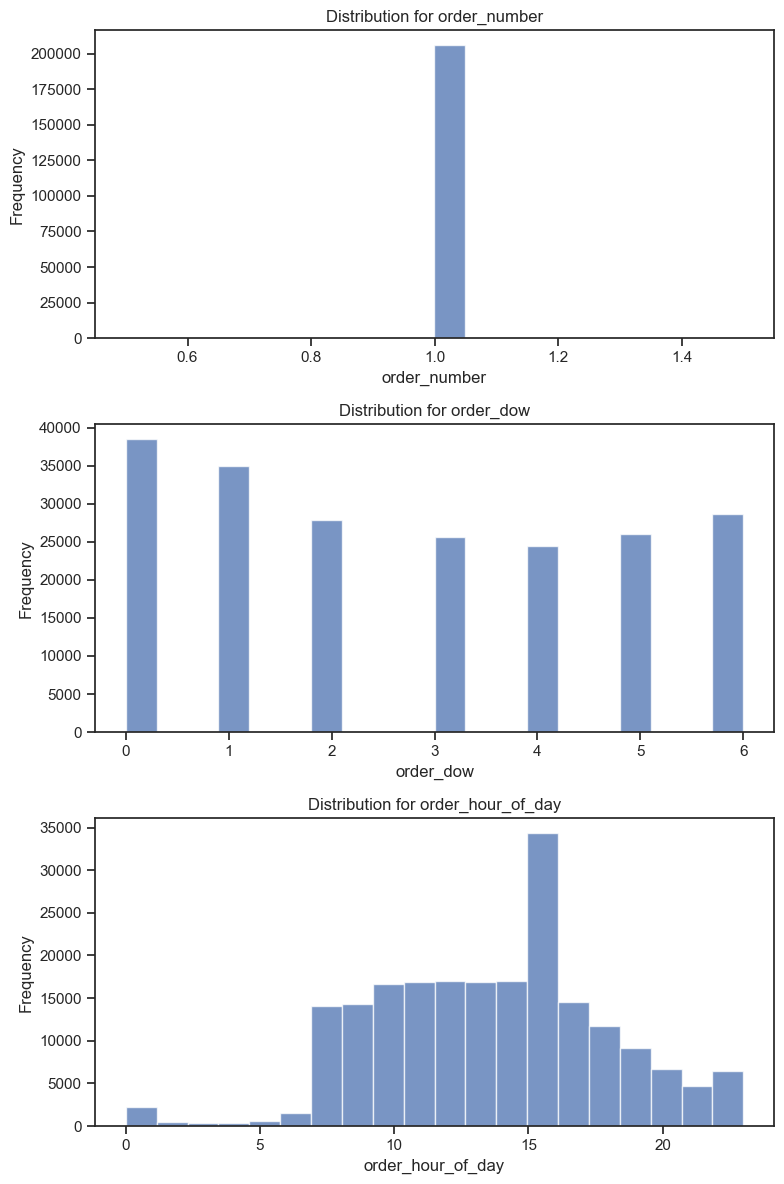

In [226]:
cols_to_check = ['order_number', 'order_dow', 'order_hour_of_day']

# Create subplots for each column
fig, axs = plt.subplots(len(cols_to_check), figsize=(8, 12))

# Loop through columns and create histograms
for i, col in enumerate(cols_to_check):
    axs[i].hist(orders_with_null[col], bins=20, alpha=0.75)
    axs[i].set_title(f'Distribution for {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [227]:
orders['days_since_prior_order'].unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11., 22.,  4.,  5.,  2., 23.,
       26., 25., 16.,  1., 18., 24.], dtype=float16)

It turns out that it's the **customer's first order**. No wonder it returns null, it denotes no prior purchase! We can potentially impute these null values with 0, but we note below that some customers don't wait days for their next purchase. Hence, we'll leave the null values as is for now.


In [228]:
orders_ = orders.loc[orders['days_since_prior_order'] == 0]
print(f"Num. of customers with 0 days_since_prior_order: {len(orders_)}")
orders_

Num. of customers with 0 days_since_prior_order: 67755


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
8,2295261,1,prior,9,1,16,0.00
43,2557754,4,prior,5,5,13,0.00
189,2148135,17,prior,30,6,15,0.00
296,965160,24,train,19,0,16,0.00
337,3162630,27,prior,24,2,15,0.00
...,...,...,...,...,...,...,...
3420980,4277,206206,prior,47,2,17,0.00
3420985,648225,206206,prior,52,0,19,0.00
3420991,2475308,206206,prior,58,0,15,0.00
3421001,1043943,206206,test,68,0,20,0.00


### **2.0 Conducting exploratory data analysis (EDA) to understand product purchasing patterns.**

#### 2.1 Available product categories

In [229]:
print(f"No. of unique aisles: {len(aisles['aisle'].unique())}")
aisles['aisle'].unique()

No. of unique aisles: 134


array(['prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       'cold flu allergy', 'fresh pasta', 'prepared meals',
       'tofu meat alternatives', 'packaged seafood', 'fresh herbs',
       'baking ingredients', 'bulk dried fruits vegetables',
       'oils vinegars', 'oral hygiene', 'packaged cheese', 'hair care',
       'popcorn jerky', 'fresh fruits', 'soap', 'coffee', 'beers coolers',
       'red wines', 'honeys syrups nectars', 'latino foods',
       'refrigerated', 'packaged produce', 'kosher foods',
       'frozen meat seafood', 'poultry counter', 'butter',
       'ice cream ice', 'frozen meals', 'seafood counter',
       'dog food care', 'cat food care', 'frozen vegan vegetarian',
       'buns rolls', 'eye ear care', 'candy chocolate', 'mint gum',
       'vitamins supplements', 'breakfast bars pastries',
       '

In [230]:
print(f"No. of unique departments: {len(departments['department'].unique())}")
departments['department'].unique()

No. of unique departments: 21


array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

In [231]:
print(f"No. of unique products: {len(products['product_name'].unique())}")

No. of unique products: 49688


In [232]:
products['product_name'].unique()[:50]

array(['Chocolate Sandwich Cookies', 'All-Seasons Salt',
       'Robust Golden Unsweetened Oolong Tea',
       'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce',
       'Green Chile Anytime Sauce', 'Dry Nose Oil',
       'Pure Coconut Water With Orange',
       "Cut Russet Potatoes Steam N' Mash",
       'Light Strawberry Blueberry Yogurt',
       'Sparkling Orange Juice & Prickly Pear Beverage',
       'Peach Mango Juice', 'Chocolate Fudge Layer Cake',
       'Saline Nasal Mist', 'Fresh Scent Dishwasher Cleaner',
       'Overnight Diapers Size 6', 'Mint Chocolate Flavored Syrup',
       'Rendered Duck Fat', 'Pizza for One Suprema  Frozen Pizza',
       'Gluten Free Quinoa Three Cheese & Mushroom Blend',
       'Pomegranate Cranberry & Aloe Vera Enrich Drink',
       'Small & Medium Dental Dog Treats',
       'Fresh Breath Oral Rinse Mild Mint', 'Organic Turkey Burgers',
       'Tri-Vi-Sol® Vitamins A-C-and D Supplement Drops for Infants',
       'Salted Caramel Lean 

In [233]:
products_2 = products.merge(aisles, how='left', on="aisle_id") \
                     .merge(departments, how='left', on="department_id")

In [234]:
# Top 10 departments with the largest offerings
products_2.groupby(['department']).agg(Count=('product_name', 'count')) \
          .sort_values(by='Count', ascending=False)[:10]

,Count
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007
dairy eggs,3449
household,3085
canned goods,2092
dry goods pasta,1858


In [235]:
# Top 10 aisles with the largest offerings. Perhaps the `missing` category a catch-all category?
products_2.groupby(['aisle']).agg(Count=('product_name', 'count')) \
          .sort_values(by='Count', ascending=False)[:10]

,Count
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026
chips pretzels,989
tea,894
packaged cheese,891
frozen meals,880


#### 2.2 Customer purchasing behavior

From the histogram below, **most orders take place between 8.00-18.00.**

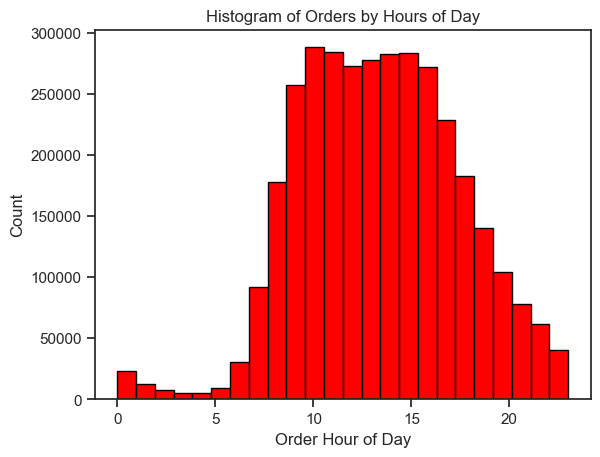

In [236]:
# Create a histogram using Matplotlib
num_bins = orders['order_hour_of_day'].nunique()
plt.hist(orders['order_hour_of_day'], bins=num_bins, color='red', edgecolor='black')

# Add labels and a title
plt.xlabel('Order Hour of Day')
plt.ylabel('Count')
plt.title('Histogram of Orders by Hours of Day')

# Show the plot
plt.show()

**Most orders are on days 0 and 1**. While there is no designation as to what each day stands for numerically, we can perhaps assume it's during the weekend as people set their orders for the rest of the week.

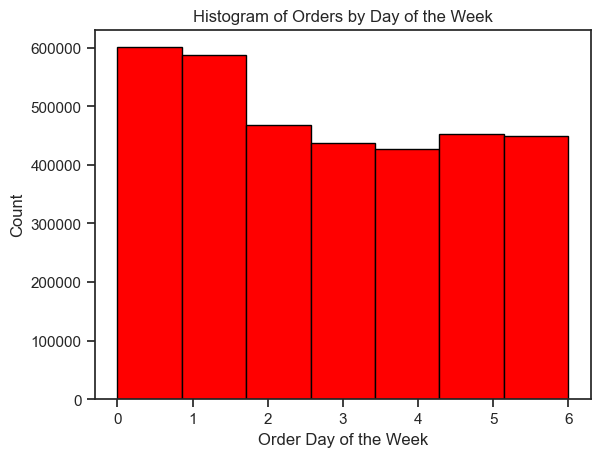

In [237]:
num_bins = orders['order_dow'].nunique()
plt.hist(orders['order_dow'], bins=num_bins, color='red', edgecolor='black')

plt.xlabel('Order Day of the Week')
plt.ylabel('Count')
plt.title('Histogram of Orders by Day of the Week')

plt.show()

Drilling down, we can see that the most important time periods for the above two days are from **9am - 11am** for day 1, and **1pm - 3 pm** for day 0.

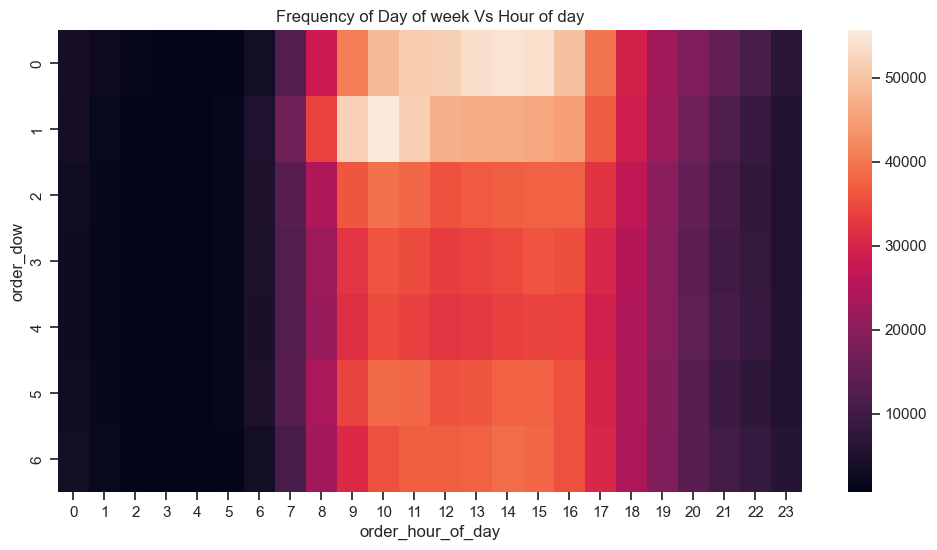

In [238]:
grouped_orders_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_orders_df
grouped_orders_df = grouped_orders_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_orders_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

People also seem to **order more often after exactly 1 week or 1 month.**

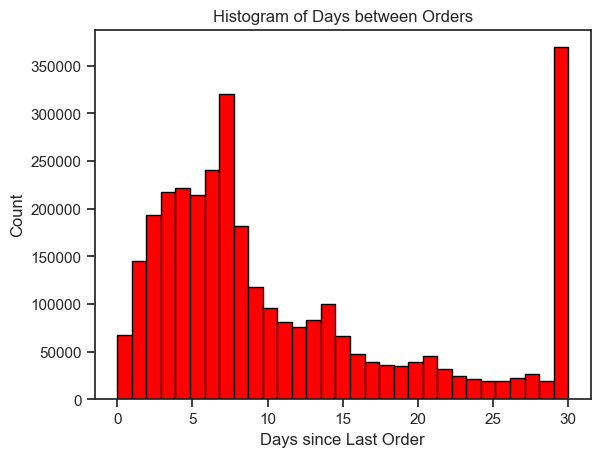

In [239]:
num_bins = orders['days_since_prior_order'].nunique()
plt.hist(orders['days_since_prior_order'], bins=num_bins, color='red', edgecolor='black')

plt.xlabel('Days since Last Order')
plt.ylabel('Count')
plt.title('Histogram of Days between Orders')

plt.show()

In terms of the number of items in every order, distributions in both `order_products` & `order_products_train` are relatively similar. Important things to highlight:

- On average, people mostly purchase 10 items in every order.
- The maximum number of orders in a particular order is 80 in `order_products` & 145 in `order_products_train`.

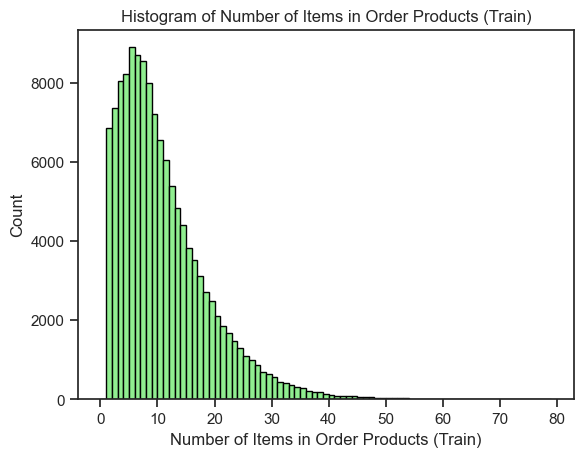

In [240]:
# Group by 'order_id' and calculate 'n_items' as the last 'add_to_cart_order' value
grouped_train = order_products.groupby('order_id')['add_to_cart_order'].last().reset_index()
grouped_train.columns = ['order_id', 'n_items']

# Create a histogram using Matplotlib
plt.hist(grouped_train['n_items'], bins=range(0,80), color='lightgreen', edgecolor='black')

# Add labels and a title
plt.xlabel('Number of Items in Order Products (Train)')
plt.ylabel('Count')
plt.title('Histogram of Number of Items in Order Products (Train)')

# Show the plot
plt.show()

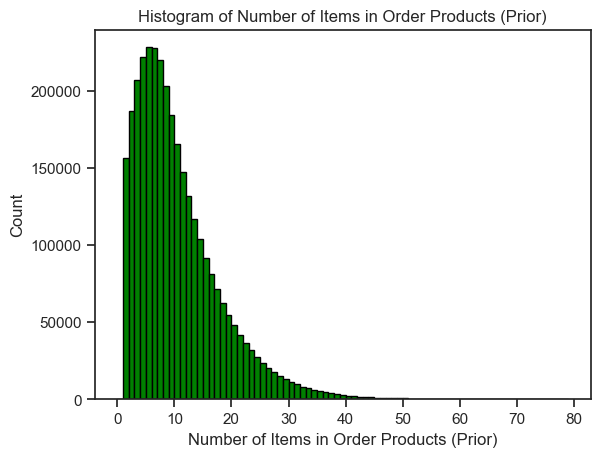

In [241]:
# Group by 'order_id' and calculate 'n_items' as the last 'add_to_cart_order' value
grouped_prior = order_products_prior.groupby('order_id')['add_to_cart_order'].last().reset_index()
grouped_prior.columns = ['order_id', 'n_items']

# Create a histogram using Matplotlib
plt.hist(grouped_prior['n_items'], bins=range(0,80), color='green', edgecolor='black')

# Add labels and a title
plt.xlabel('Number of Items in Order Products (Prior)')
plt.ylabel('Count')
plt.title('Histogram of Number of Items in Order Products (Prior)')

# Show the plot
plt.show()

In [242]:
# Calculate summary statistics for 'n_items' in both DataFrames
summary_train = grouped_train['n_items'].describe()
summary_prior = grouped_prior['n_items'].describe()

# Concatenate the summary statistics vertically
pd.set_option('display.float_format', '{:.2f}'.format)
combined_summary = pd.concat([summary_train, summary_prior], axis=1)

# Rename the columns for clarity
combined_summary.columns = ['Train', 'Prior']

# Display the combined summary table
print(combined_summary)

          Train      Prior
count 131209.00 3214874.00
mean      10.55      10.09
std        7.93       7.53
min        1.00       1.00
25%        5.00       5.00
50%        9.00       8.00
75%       14.00      14.00
max       80.00     145.00


Overall, the vast majority of products are reorders (~60%). While it's good that this shows customer loyalty this can potentially be interpreted as:
1. Posing an issue when attempting to promote new products in the future.
2. The lack of effectiveness of campaigns promoting new products.  

In [243]:
print(f"Reorder rate in `order_products_prior`:\n {order_products_prior['reordered'].value_counts(normalize=True)}")
print("")
print(f"Reorder rate in `order_products`:\n {order_products['reordered'].value_counts(normalize=True)}")

Reorder rate in `order_products_prior`:
 reordered
1   0.59
0   0.41
Name: proportion, dtype: float64

Reorder rate in `order_products`:
 reordered
1   0.60
0   0.40
Name: proportion, dtype: float64


#### 2.3 Top 10 Bestsellers & products with the highest `reorder_rates`

##### 2.3.1 Top 10 Bestsellers

The **Top 10 products** are also similar across the Prior & Train evaluations sets. **Bananas** is the undisputed bestseller!

In [244]:
num_purchase_by_product_train = order_products.groupby(['product_id']) \
                    .agg(NumPurchases=('product_id', 'count')) \
                    .merge(products, how='left', on='product_id') \
                    .sort_values(by='NumPurchases', ascending=False)
num_purchase_by_product_train[:10]

,product_id,NumPurchases,product_name,aisle_id,department_id
19574,24852,18726,Banana,24,4
10367,13176,15480,Bag of Organic Bananas,24,4
16685,21137,10894,Organic Strawberries,24,4
17300,21903,9784,Organic Baby Spinach,123,4
37499,47626,8135,Large Lemon,24,4
37609,47766,7409,Organic Avocado,24,4
37164,47209,7293,Organic Hass Avocado,24,4
13228,16797,6494,Strawberries,24,4
20648,26209,6033,Limes,24,4
22024,27966,5546,Organic Raspberries,123,4


In [245]:
num_purchase_by_product_prior = order_products_prior.groupby(['product_id']) \
                    .agg(NumPurchases=('product_id', 'count')) \
                    .merge(products, how='left', on='product_id') \
                    .sort_values(by='NumPurchases', ascending=False)
num_purchase_by_product_prior[:10]

,product_id,NumPurchases,product_name,aisle_id,department_id
24848,24852,472565,Banana,24,4
13172,13176,379450,Bag of Organic Bananas,24,4
21133,21137,264683,Organic Strawberries,24,4
21899,21903,241921,Organic Baby Spinach,123,4
47198,47209,213584,Organic Hass Avocado,24,4
47755,47766,176815,Organic Avocado,24,4
47615,47626,152657,Large Lemon,24,4
16793,16797,142951,Strawberries,24,4
26204,26209,140627,Limes,24,4
27839,27845,137905,Organic Whole Milk,84,16



##### 2.3.2 `reorder_rate` for every product

Let's now look at each product's `reorder_rate`.

In [246]:
df_reorders_train = order_products.groupby(['product_id']) \
                            .agg(NumOrders=('product_id', 'count'), 
                                 NumReorders=('reordered', 'sum')) \
                            .merge(products, how='left', on='product_id')
df_reorders_train['reorder_rate'] = df_reorders_train['NumReorders'] / df_reorders_train['NumOrders']
df_reorders_train.sort_values('reorder_rate', ascending=False, inplace=True)
df_reorders_train

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,reorder_rate
19561,24836,1,1,"Cat Litter, Scoopable, Scented",41,8,1.00
5283,6708,1,1,Orange Navel,24,4,1.00
23610,29977,1,1,Bacon Style Slices,14,20,1.00
23618,29988,2,2,Chocolate Granola Bars,3,19,1.00
23628,30002,1,1,Antioxidant Blend Frozen Smoothie,116,1,1.00
...,...,...,...,...,...,...,...
4155,5243,1,0,Big Cup Noodles Homestyle Shrimp Flavor,66,6,0.00
17564,22243,3,0,On The Go Chicken with Mini Noodles Soup,69,15,0.00
2387,3003,2,0,Ale Premier,27,5,0.00
31985,40609,1,0,Rosemary Flaxseed Crackers,100,21,0.00


Reorder rates become pretty meaningless if they've only been ordered once. Hence, we'll aim to only look at `reorder_rate`'s for products with more orders than the mean `NumOrders` (~35).

In [247]:
df_reorders_train['NumOrders'].describe()

count   39123.00
mean       35.39
std       222.53
min         1.00
25%         2.00
50%         5.00
75%        18.00
max     18726.00
Name: NumOrders, dtype: float64

In [248]:
df_reorders_train_final = df_reorders_train.query("NumOrders >= 35")

# Top 10 products with the highest reorder rates in the train evaluation set
df_reorders_train_final[:10]

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,reorder_rate
1374,1729,92,86,2% Lactose Free Milk,84,16,0.93
24121,30630,35,32,"Yogurt, Sheep Milk, Blackberry",120,16,0.91
16529,20940,368,336,Organic Low Fat Milk,84,16,0.91
9571,12193,59,53,100% Florida Orange Juice,98,7,0.90
25006,31764,45,40,Original Sparkling Seltzer Water Cans,115,7,0.89
16610,21038,81,72,Organic Spelt Tortillas,128,3,0.89
38529,48927,35,31,Fat Free Plain Yoghurt,120,16,0.89
19574,24852,18726,16557,Banana,24,4,0.88
100,117,120,106,Petit Suisse Fruit,2,16,0.88
30852,39180,483,426,Organic Lowfat 1% Milk,84,16,0.88


We see an entirely different set of products with high reorder rates in the Prior evaluation set. 

**NOTE**: Due to the larger num. of orders in general, we'll use the 75th percentile instead of the mean (as per above).

In [249]:
# for prior evaluation set
df_reorders_prior = order_products_prior.groupby(['product_id']) \
                            .agg(NumOrders=('product_id', 'count'), 
                                 NumReorders=('reordered', 'sum')) \
                            .merge(products, how='left', on='product_id') \
                            .merge(aisles, how='left', on='aisle_id') \
                            .merge(departments, how='left', on='department_id')
df_reorders_prior['reorder_rate'] = df_reorders_prior['NumReorders'] / df_reorders_prior['NumOrders']
df_reorders_prior.sort_values('reorder_rate', ascending=False, inplace=True)
df_reorders_prior['NumOrders'].mean()

652.90756285605

In [250]:
df_reorders_prior['NumOrders'].describe()

count    49677.00
mean       652.91
std       4792.11
min          1.00
25%         17.00
50%         60.00
75%        260.00
max     472565.00
Name: NumOrders, dtype: float64

In [251]:
df_reorders_prior_final = df_reorders_prior.query("NumOrders >= 260")

# Top 10 products with the highest reorder rates in the Prior evaluation set
df_reorders_prior_final[:10]

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,aisle,department,reorder_rate
35490,35496,451,389,Real2 Alkalized Water 500 ml,115,7,water seltzer sparkling water,beverages,0.86
9288,9292,2921,2517,Half And Half Ultra Pasteurized,84,16,milk,dairy eggs,0.86
45495,45504,9108,7835,Whole Organic Omega 3 Milk,84,16,milk,dairy eggs,0.86
43386,43394,8477,7282,Organic Lactose Free Whole Milk,91,16,soy lactosefree,dairy eggs,0.86
5511,5514,3970,3405,Organic Homogenized Whole Milk,84,16,milk,dairy eggs,0.86
47220,47231,1489,1277,Ultra-Purified Water,115,7,water seltzer sparkling water,beverages,0.86
17465,17469,467,400,Lo-Carb Energy Drink,64,7,energy sports drinks,beverages,0.86
29441,29447,20198,17256,"Milk, Organic, Vitamin D",84,16,milk,dairy eggs,0.85
38681,38689,35663,30338,Organic Reduced Fat Milk,84,16,milk,dairy eggs,0.85
34191,34197,5185,4407,Goat Milk,84,16,milk,dairy eggs,0.85


##### 2.3.3 Relationship between the number of orders and `reorder_rate`

While more number of orders generally means higher `reorder_rate`s, the correlation is tenuous (0.17) at best.

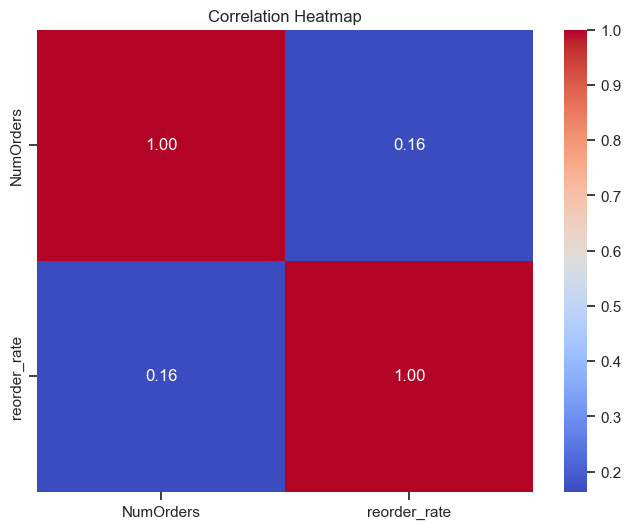

In [252]:
# Calculate the correlation matrix
correlation_matrix = df_reorders_prior_final[["NumOrders", "reorder_rate"]].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

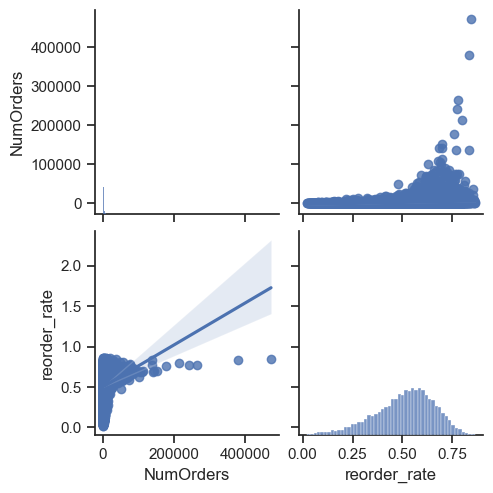

In [253]:
# Create a pairplot with regression lines
sns.set(style='ticks')
sns.pairplot(df_reorders_prior_final[["NumOrders", "reorder_rate"]], kind='reg')

# Show the plot
plt.show()

##### 2.3.4 Aisles with the highest & lowest reorder rates

In [254]:
# the top 5 aisles with the lowest & highest reorder rates
df_reorders_prior_final.groupby(['aisle_id']) \
                       .agg(ReorderRateByAisle=('reorder_rate', 'median')) \
                       .sort_values("ReorderRateByAisle", ascending=False) \
                       .merge(aisles, how="left", on="aisle_id")

,aisle_id,ReorderRateByAisle,aisle
0,84,0.73,milk
1,115,0.70,water seltzer sparkling water
2,86,0.69,eggs
3,41,0.66,cat food care
4,120,0.66,yogurt
...,...,...,...
129,80,0.19,deodorants
130,97,0.18,baking supplies decor
131,118,0.17,first aid
132,44,0.16,eye ear care


In [255]:
df_reorders_prior_final.head(3)

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,aisle,department,reorder_rate
35490,35496,451,389,Real2 Alkalized Water 500 ml,115,7,water seltzer sparkling water,beverages,0.86
9288,9292,2921,2517,Half And Half Ultra Pasteurized,84,16,milk,dairy eggs,0.86
45495,45504,9108,7835,Whole Organic Omega 3 Milk,84,16,milk,dairy eggs,0.86


Below, we can figure out which aisles have the highest number of orders within each department.

**NOTE:** `grouped.groupby(["department"])` is a Pandas DataFrameGroupBy object. It's not an iterable like a list or a tuple. However, we can iterate through the groups created by groupby using a for loop. Each iteration provides a tuple where the first element is the group key (in this case, the *department*) and the second element is a DataFrame containing the rows corresponding to that department.

In [256]:
# Format y-axis labels as non-scientific notation
def format_func(value, tick_number):
    return '{:,.0f}'.format(value)

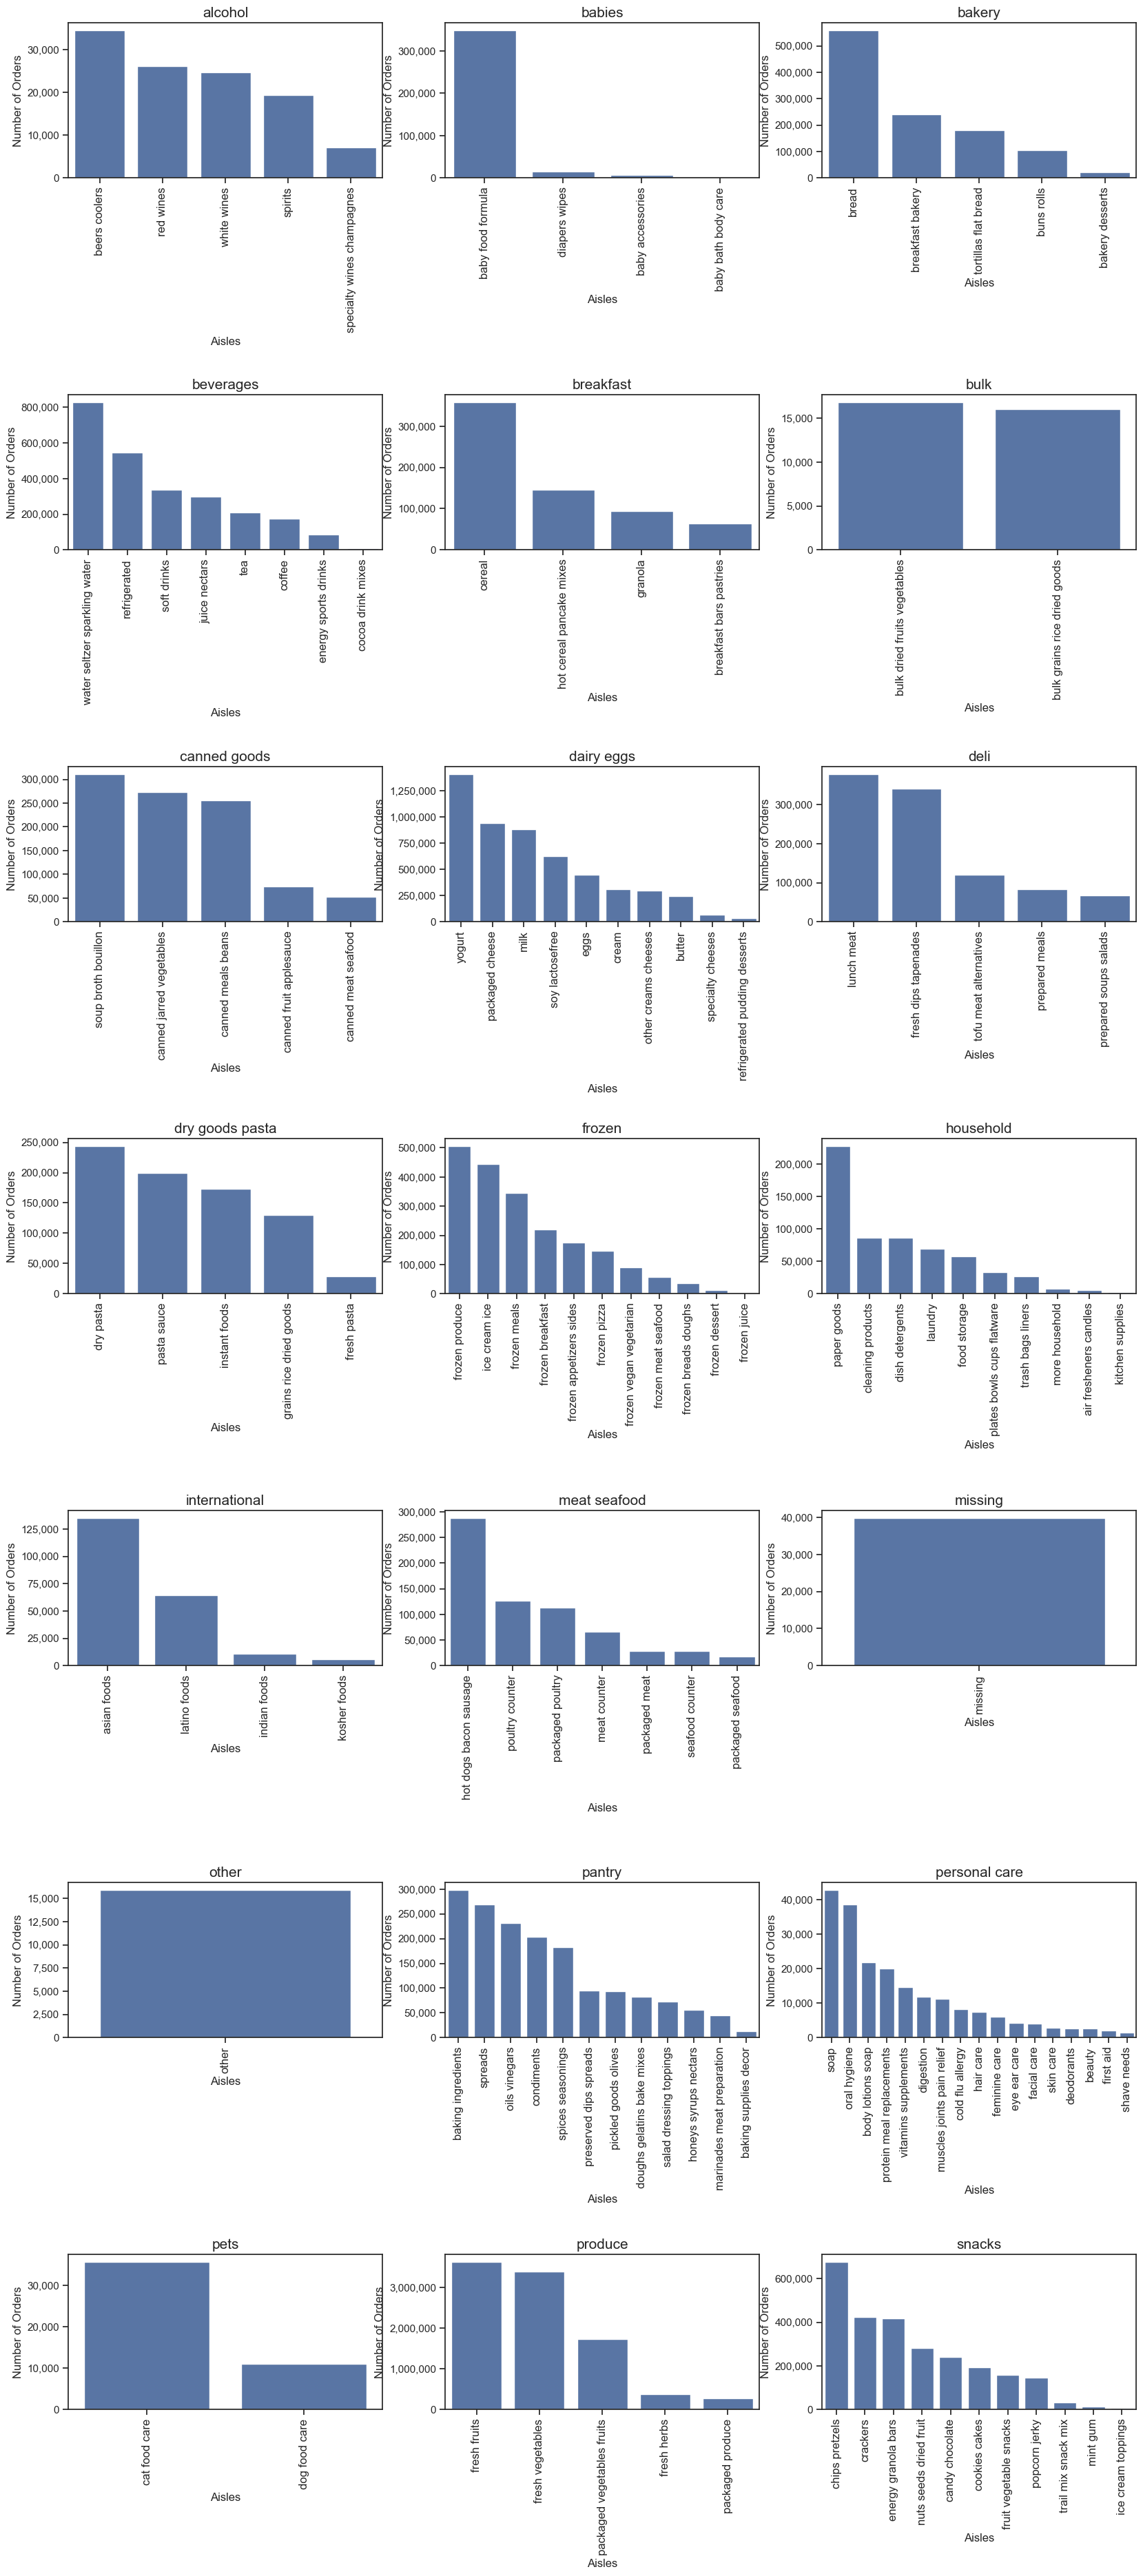

In [257]:
grouped = df_reorders_prior_final.groupby(["department", "aisle"]).aggregate(Total_orders=('NumOrders', 'sum')).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (department, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x=group.aisle, y=group.Total_orders, ax=ax)
    ax.set(xlabel = "Aisles", ylabel="Number of Orders")

    # Set the number ticks first
    ax.set_xticks(range(len(group["aisle"])))
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)

    # Disable scientific notation for y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.set_title(department[0], fontsize=15)

Within departments, how do the reorder rates differ between different aisles? We can answer that below by analysing the median reorder rate within each aisle. 

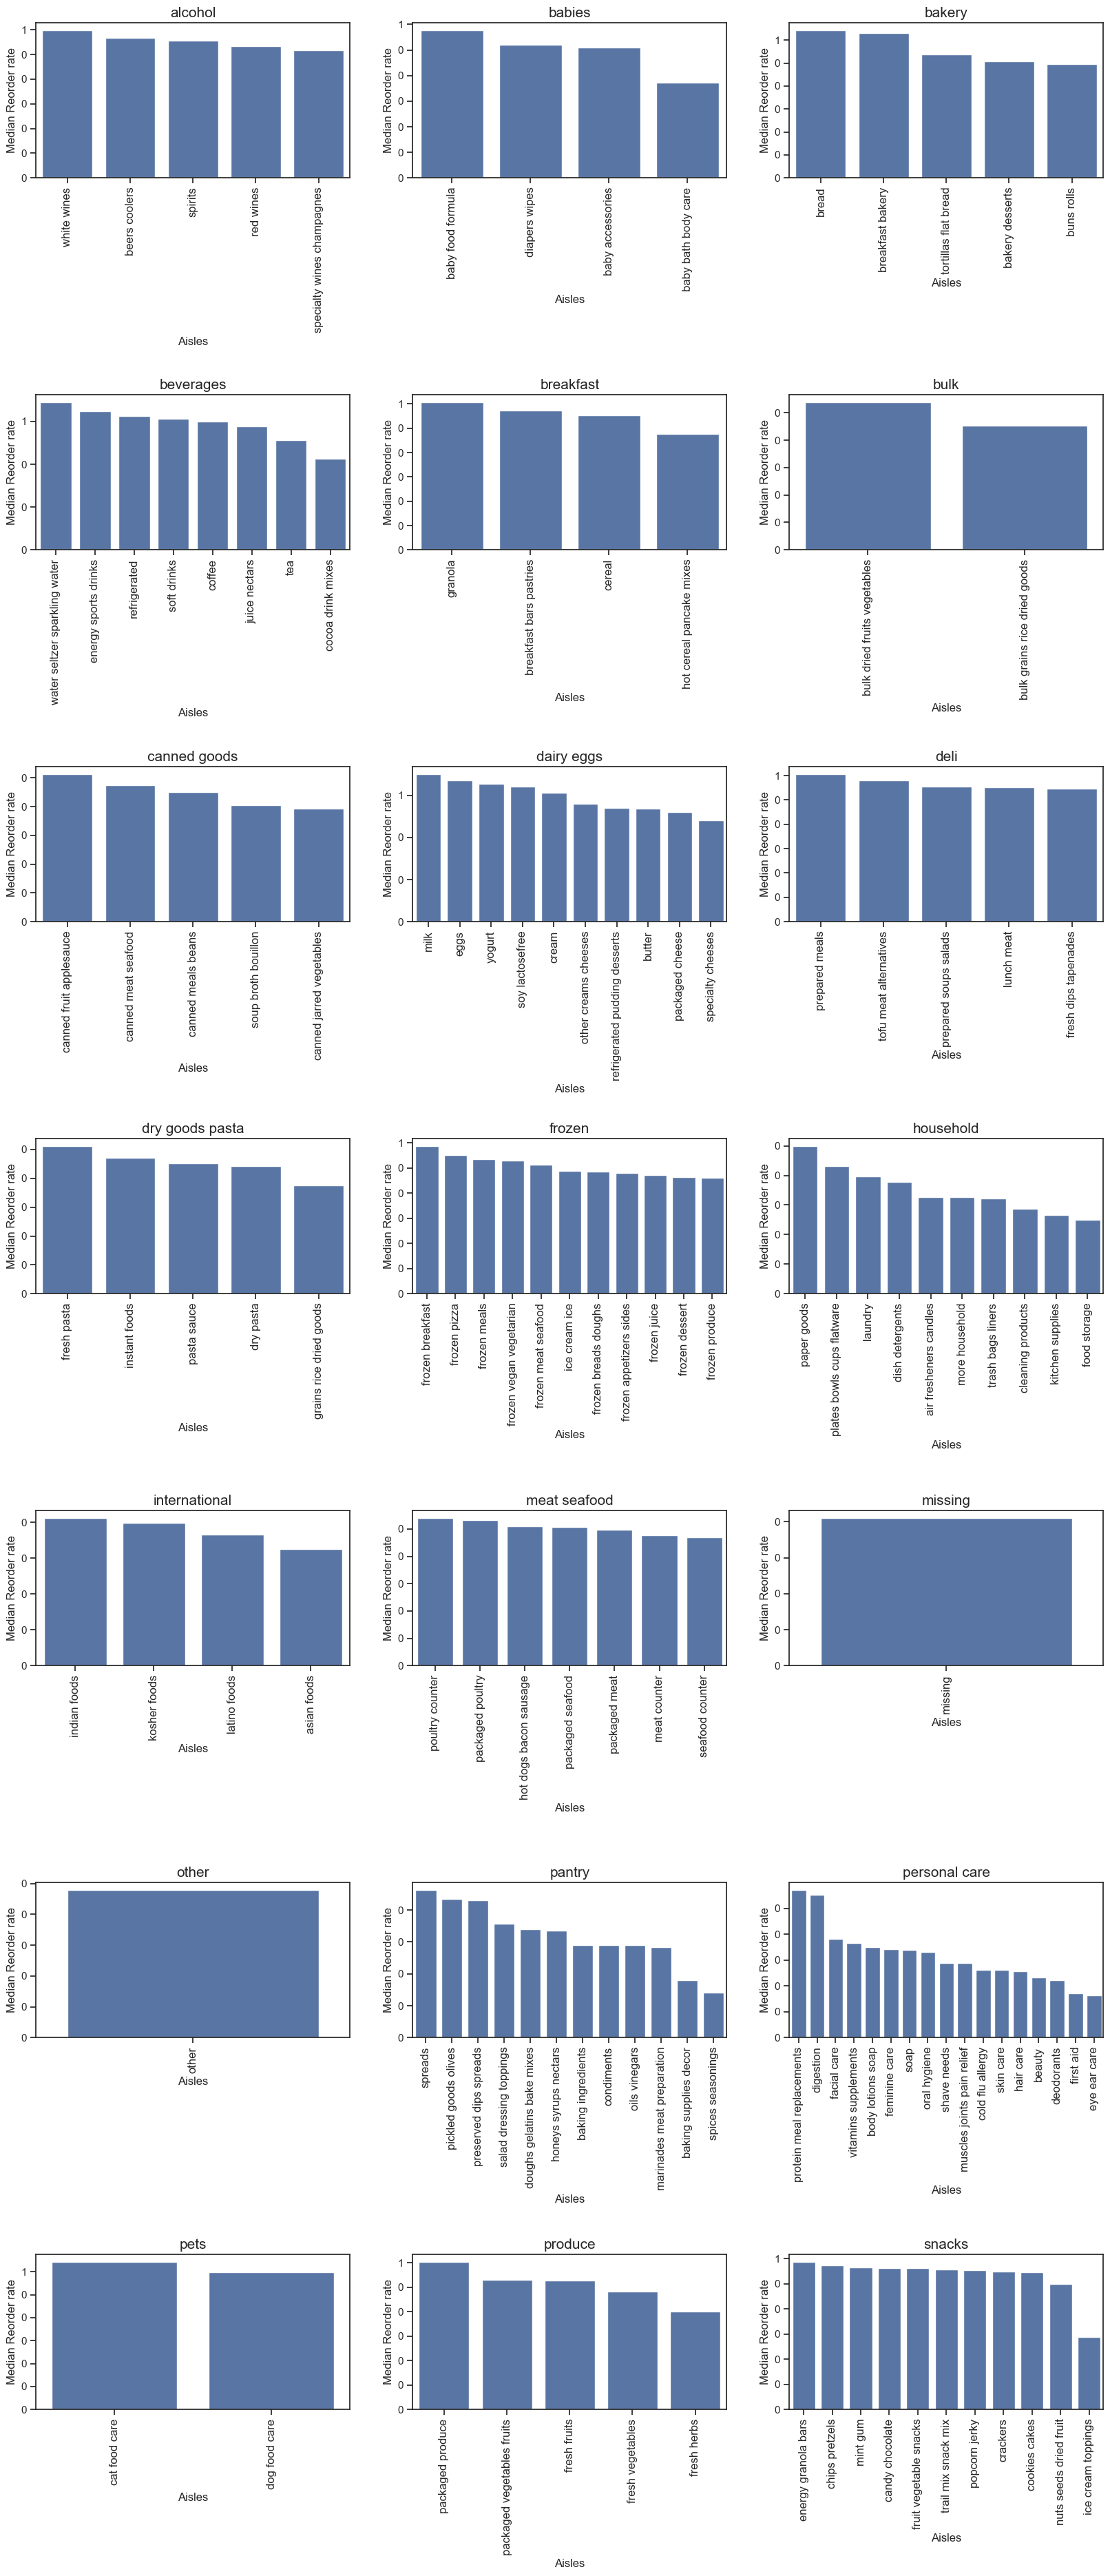

In [258]:
grouped = df_reorders_prior_final.groupby(["department", "aisle"]) \
                                 .aggregate(Total_orders=('reorder_rate', 'mean')) \
                                 .reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (department, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x=group.aisle, y=group.Total_orders, ax=ax)
    ax.set(xlabel = "Aisles", ylabel="Median Reorder rate")

    # Set the number ticks first
    ax.set_xticks(range(len(group["aisle"])))
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)

    # Disable scientific notation for y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.set_title(department[0], fontsize=15)

### **3.0 Visualize the top 10 most frequently bought products and their respective reorder rates.**

In [268]:
df_reorders_train_final.sort_values('NumOrders', ascending=False)[:10]

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,reorder_rate
19574,24852,18726,16557,Banana,24,4,0.88
10367,13176,15480,13362,Bag of Organic Bananas,24,4,0.86
16685,21137,10894,8603,Organic Strawberries,24,4,0.79
17300,21903,9784,8055,Organic Baby Spinach,123,4,0.82
37499,47626,8135,5923,Large Lemon,24,4,0.73
37609,47766,7409,6226,Organic Avocado,24,4,0.84
37164,47209,7293,6042,Organic Hass Avocado,24,4,0.83
13228,16797,6494,4786,Strawberries,24,4,0.74
20648,26209,6033,4234,Limes,24,4,0.70
22024,27966,5546,4279,Organic Raspberries,123,4,0.77


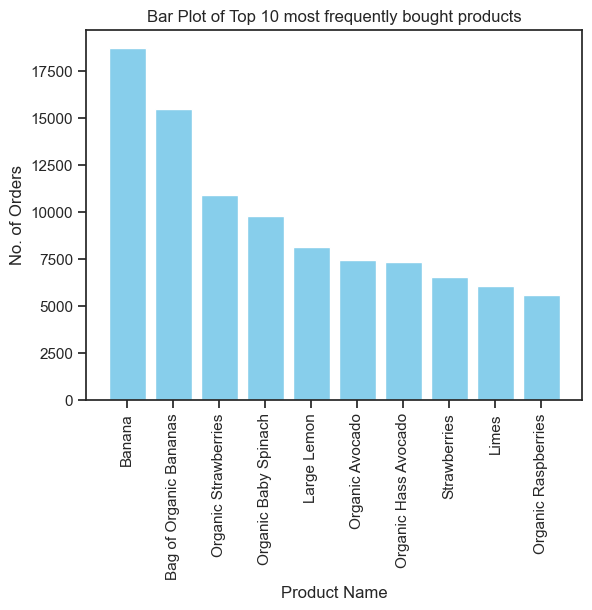

In [259]:
# Top 10 most frequently bought products
plt.bar(num_purchase_by_product_train['product_name'][:10], 
        num_purchase_by_product_train['NumPurchases'][:10],
        color='skyblue')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)  # Set rotation angle to 90 degrees

# Add labels and a title
plt.xlabel('Product Name')
plt.ylabel('No. of Orders')
plt.title('Bar Plot of Top 10 most frequently bought products')

# Show the plot
plt.show()

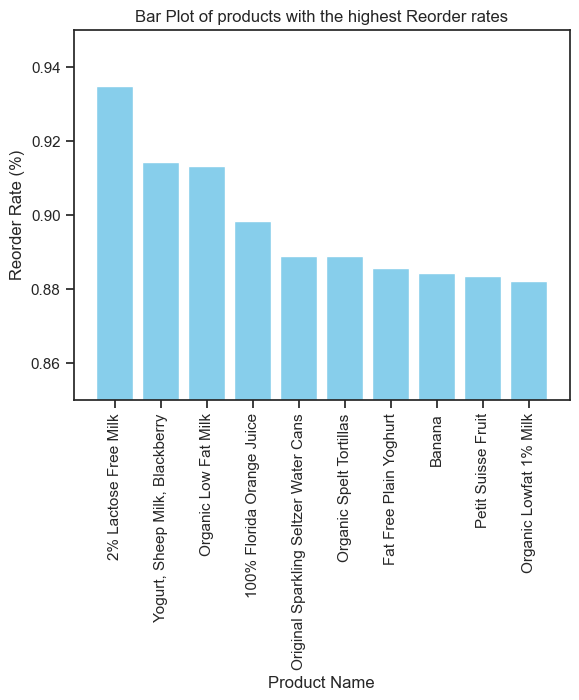

In [264]:
# Top 10 most frequently reordered products
plt.bar(df_reorders_train_final['product_name'][:10], 
        df_reorders_train_final['reorder_rate'][:10],
        color='skyblue')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)  # Set rotation angle to 90 degrees

# Set the range for the x-axis
plt.ylim(0.85, 0.95)  # Adjust the range as needed

# Add labels and a title
plt.xlabel('Product Name')
plt.ylabel('Reorder Rate (%)')
plt.title('Bar Plot of products with the highest Reorder rates')

# Show the plot
plt.show()

In [269]:
df_reorders_prior_final.sort_values('NumOrders', ascending=False)[:10]

,product_id,NumOrders,NumReorders,product_name,aisle_id,department_id,aisle,department,reorder_rate
24848,24852,472565,398609,Banana,24,4,fresh fruits,produce,0.84
13172,13176,379450,315913,Bag of Organic Bananas,24,4,fresh fruits,produce,0.83
21133,21137,264683,205845,Organic Strawberries,24,4,fresh fruits,produce,0.78
21899,21903,241921,186884,Organic Baby Spinach,123,4,packaged vegetables fruits,produce,0.77
47198,47209,213584,170131,Organic Hass Avocado,24,4,fresh fruits,produce,0.80
47755,47766,176815,134044,Organic Avocado,24,4,fresh fruits,produce,0.76
47615,47626,152657,106255,Large Lemon,24,4,fresh fruits,produce,0.70
16793,16797,142951,99802,Strawberries,24,4,fresh fruits,produce,0.70
26204,26209,140627,95768,Limes,24,4,fresh fruits,produce,0.68
27839,27845,137905,114510,Organic Whole Milk,84,16,milk,dairy eggs,0.83


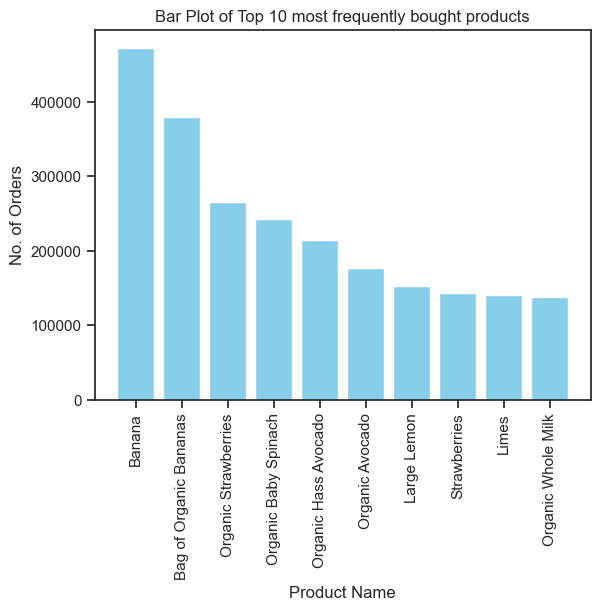

In [271]:
# Top 10 most frequently bought products
plt.bar(num_purchase_by_product_prior['product_name'][:10], 
        num_purchase_by_product_prior['NumPurchases'][:10],
        color='skyblue')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)  # Set rotation angle to 90 degrees

# Add labels and a title
plt.xlabel('Product Name')
plt.ylabel('No. of Orders')
plt.title('Bar Plot of Top 10 most frequently bought products')

# Show the plot
plt.show()

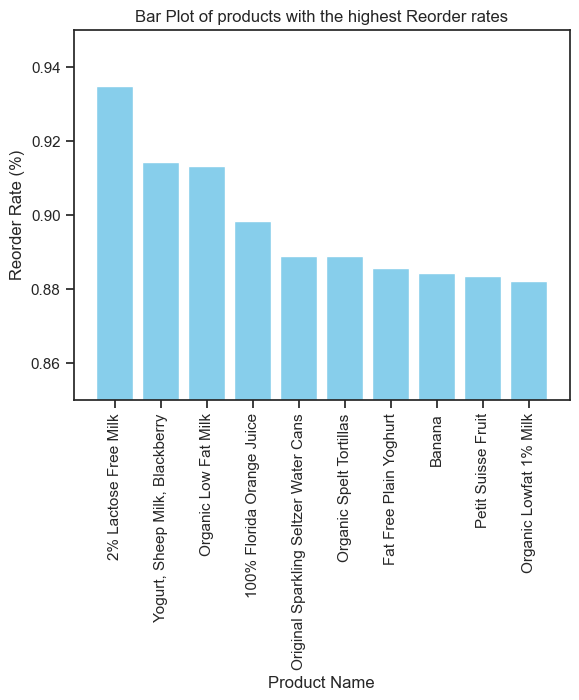

In [270]:
# Top 10 most frequently reordered products
plt.bar(df_reorders_train_final['product_name'][:10], 
        df_reorders_train_final['reorder_rate'][:10],
        color='skyblue')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)  # Set rotation angle to 90 degrees

# Set the range for the x-axis
plt.ylim(0.85, 0.95)  # Adjust the range as needed

# Add labels and a title
plt.xlabel('Product Name')
plt.ylabel('Reorder Rate (%)')
plt.title('Bar Plot of products with the highest Reorder rates')

# Show the plot
plt.show()

### 4.0 **Additional analyses to be conducted in the future**
- Comparison of products that are Organic vs Non-Organic, Fruits vs Vegetables, Food items vs Non-food items
- An analysis of items that are ordered first on Instacart (useful for finding which products are good *entry points* for Instacart's offerings)
- An analysis on the association between time of last order and probability of reorder
- Add-to-cart order vs Reorder rate
- More in-depth breakdowns of results by aisle/product category.